## CTD Transect Report, Lake Lucerne, 30/10/2025

In [1]:
# imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

In [2]:
path = "Q:/Messdaten/Aphys_Hypothesis_data/Lucerne/2025/20251030_CTD/"

In [3]:
def create_file_list(path):
    filetypes = {".tob": "sea&sun", ".rsk": "rbr", ".cnv": "seabird"}
    file_groups = {}
    files = []
    for file in os.listdir(path):
        base_name, extension = os.path.splitext(file)
        if base_name not in file_groups:
            file_groups[base_name] = []
        file_groups[base_name].append(extension)
    for base_name, ext_list in file_groups.items():
        matching_key = next((key for key in ext_list if key.lower() in filetypes), None)
        if matching_key is not None:
            files.append({
                "basename": base_name,
                "extension": matching_key,
                "files": ext_list,
                "type": filetypes[matching_key.lower()],
                "path": os.path.join(path, base_name + matching_key)
            })
    return files


def rename_duplicates(arr):
    out = []
    d = {}
    for i in arr:
        d.setdefault(i, -1)
        d[i] += 1
        if d[i] >= 1:
            out.append('%s%d' % (i, d[i]))
        else:
            out.append(i)
    return out


def parse_time(df):
    if "IntD" in df.columns and "IntT" in df.columns:
        return pd.to_datetime(df["IntD"].str.replace('/', '.', regex=False) + " " + df["IntT"], format="%d.%m.%Y %H:%M:%S.%f", dayfirst=True)
    elif "IntDT" in df.columns and "IntDT1" in df.columns:
        return pd.to_datetime(df["IntDT"].str.replace('/', '.', regex=False) + " " + df["IntDT1"], format="%d.%m.%Y %H:%M:%S.%f", dayfirst=True)
    elif "IntT" in df.columns and "IntT1" in df.columns:
        return pd.to_datetime(df["IntT"].str.replace('/', '.', regex=False) + " " + df["IntT1"], format="%d.%m.%Y %H:%M:%S.%f", dayfirst=True)


def parse_sea_and_sun(input_file_path, string):
    valid = True
    with open(input_file_path, encoding="latin1", errors='ignore') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if string in lines[i]:
            break
    columns = lines[i + 2].replace(";", "").split()
    columns.pop(0)
    columns = rename_duplicates(columns)
    units = lines[i + 3].replace(";", "").replace("[", "").replace("]", "").replace("°", "deg").split()
    skip_rows = i + 5
    n = 0
    while len(lines[i + 5].split()) - 1 > len(columns):
        columns.append(n)
        n = n + 1
    if len(lines) <= skip_rows + 1 or len(columns) < 5:
        valid = False
    return skip_rows, columns, units, valid


def casts_to_profiles(df, downcast, upcast, file_path, file_type, air_pressure):
    profiles = []
    for index, cast in enumerate(downcast):
        if index == 0:
            name = os.path.splitext(os.path.basename(file_path))[0]
        else:
            name = os.path.splitext(os.path.basename(file_path))[0] + "_{}".format(index)
        bottom = cast[-1] - cast[0]
        df_profile = df.iloc[cast[0]: upcast[index][-1] + 1]
        data = {
            "name": name,
            "file": os.path.basename(file_path),
            "folder": os.path.dirname(file_path),
            "type": file_type,
            "bottom_index": bottom,
            "data": df_profile
        }
        if air_pressure:
            data["air_pressure"] = air_pressure
        profiles.append(data)
    return profiles



def extract_single_profile(df, rolling=3, diff=0.01, var="Cond", pressure="Press", max_pressure_cut=3.0):
    start_index = 0
    pressure_arr = np.array(df[pressure])
    var_arr = np.array(df[var])
    air_pressure = False
    try:
        max_start = np.min(pressure_arr) + max_pressure_cut
        df = pd.DataFrame(var_arr)
        df_mean = df.rolling(rolling, center=True).mean().bfill().ffill()
        df_diff = df_mean.diff()
        outliers = np.array(np.abs(df_diff) > diff).flatten()
        start_index = np.where(outliers[:np.argmax(pressure_arr > max_start)])[0][-1]
    except:
        print("Failed to locate start of profile")
        #logging.warning("Failed to locate start of profile")
    bottom_index = np.argmax(pressure_arr)
    downcast = [list(range(start_index, bottom_index + 1))]
    upcast = [list(range(bottom_index + 1, len(df)))]
    if start_index > 0:
        air_pressure = np.nanmean(pressure_arr[:start_index])
    return downcast, upcast, air_pressure


def read_sea_and_sun(file_path):
    column_conversion = {
        "Tur": "Turb",
    }
    skip_rows, columns, units, valid = parse_sea_and_sun(file_path, "Lines :")
    if not valid:
        return False
    df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=skip_rows, names=columns, engine='python',
                     encoding="cp1252")
    columns = list(df.columns)
    for i in range(len(df.columns)):
        if df.columns[i] in column_conversion:
            columns[i] = column_conversion[df.columns[i]]
    df.columns = columns
    df["time"] = parse_time(df)
    df["time"] = df["time"].dt.tz_localize('UTC').astype("int64") // 10 ** 9
    downcast, upcast, air_pressure = extract_single_profile(df)
    profiles = casts_to_profiles(df, downcast, upcast, file_path, "Sea&Sun", air_pressure)
    if len(profiles) == 0:
        return False
    else:
        return profiles


<>:120: SyntaxWarning: invalid escape sequence '\s'
<>:120: SyntaxWarning: invalid escape sequence '\s'
C:\Users\herremha\AppData\Local\Temp\ipykernel_22252\2407051833.py:120: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', header=None, skiprows=skip_rows, names=columns, engine='python',


In [26]:
files = create_file_list(path)

In [50]:
profiles = []
for f in files:
    profiles.extend(read_sea_and_sun(f['path']))

Failed to locate start of profile
Failed to locate start of profile


In [51]:
profiles[0]

{'name': 'JB051435_1',
 'file': 'JB051435_1.TOB',
 'folder': 'Q:/Messdaten/Aphys_Hypothesis_data/Lucerne/2025/20251030_CTD',
 'type': 'Sea&Sun',
 'bottom_index': 1,
 'data':      Press     Temp    Cond   CAP25  Turb    sat  DO_mg  DO_ml  Chl_A   pH  \
 1  -0.0770  20.4801  0.0078  0.0086   0.0  93.62   8.54   5.98   6.69  7.8   
 2  -0.0735  20.4807  0.0078  0.0086   0.0  93.65   8.54   5.98   6.72  7.8   
 3  -0.0770  20.4807  0.0078  0.0086   0.0  93.63   8.54   5.98   6.69  7.8   
 4  -0.0735  20.4807  0.0066  0.0072   0.0  93.71   8.55   5.98   6.69  7.8   
 5  -0.0735  20.4807  0.0078  0.0086   0.0  93.71   8.55   5.98   6.69  7.8   
 6  -0.0770  20.4813  0.0078  0.0086   0.0  93.67   8.54   5.98   6.69  7.8   
 7  -0.0735  20.4813  0.0078  0.0086   0.0  93.66   8.54   5.98   6.72  7.8   
 8  -0.0735  20.4813  0.0078  0.0086   0.0  93.68   8.54   5.98   6.72  7.8   
 9  -0.0735  20.4819  0.0090  0.0099   0.0  93.67   8.54   5.98   6.72  7.8   
 10 -0.0735  20.4819  0.0090  0.0099 

In [4]:
def process_profiles(profiles, folder, template):
    #os.makedirs(folder, exist_ok=True)
    #pdf_pages = PdfPages(os.path.join(folder, 'profiles_requiring_metadata.pdf'))
    plots_per_page = 6
    total_plots = len(profiles)

    for i in range(0, total_plots, plots_per_page):
        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8.5, 11))
        axes = axes.flatten()

        for j in range(plots_per_page):
            plot_index = i + j
            if plot_index < total_plots:
                profile = profiles[plot_index]
                time = datetime.fromtimestamp(np.array(profile["data"]["time"])[0]).strftime('%H:%M %d %B %Y')
                x = np.array(profile["data"]["Temp"])
                y = np.array(profile["data"]["Press"]) * -1
                axes[j].plot(x, y, color="lightgrey")
                x[profile["bottom_index"] + 1:-1] = np.nan
                axes[j].plot(x, y, color="red", label=profile["type"])
                axes[j].set_title(profile["name"] + ".meta\n" + time)
                axes[j].set_xlabel("Temperature (°C)")
                axes[j].set_ylabel("Pressure (dbar)")
                axes[j].legend()
            else:
                axes[j].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        #pdf_pages.savefig(fig)
        #plt.close(fig)
        plt.show()
    #pdf_pages.close()

    """
    with open(template, 'r') as f:
        metadata = json.load(f)
    for profile in profiles:
        m = metadata.copy()
        time = datetime.fromtimestamp(np.array(profile["data"]["time"])[0])
        m["filename"] = profile["file"]
        m["campaign"]["Device"] = profile["type"]
        m["campaign"]["Date of measurement"] = time.strftime('%Y-%m-%d')
        m["profile"]["Profile name"] = profile["name"]
        m["profile"]["Time of measurement (local)"] = time.strftime('%H:%M')
        with open(os.path.join(folder, profile["name"] + ".meta"), 'w') as f:
            json.dump(m, f, indent=4)
    """

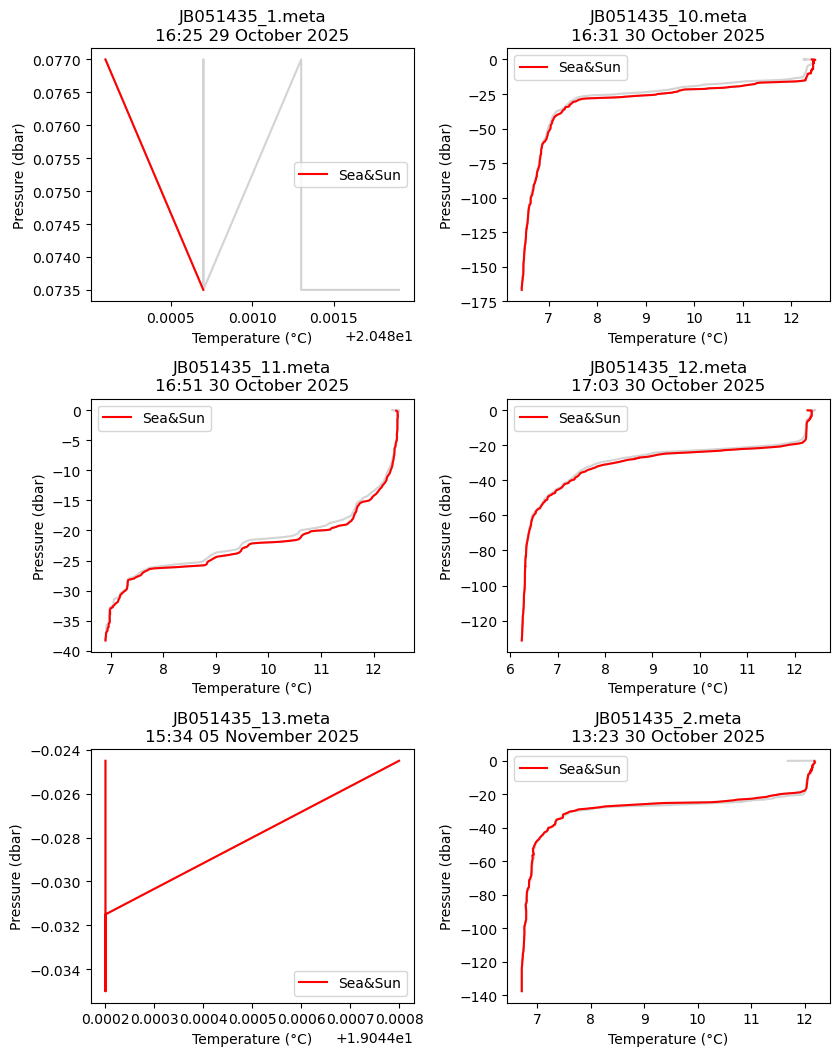

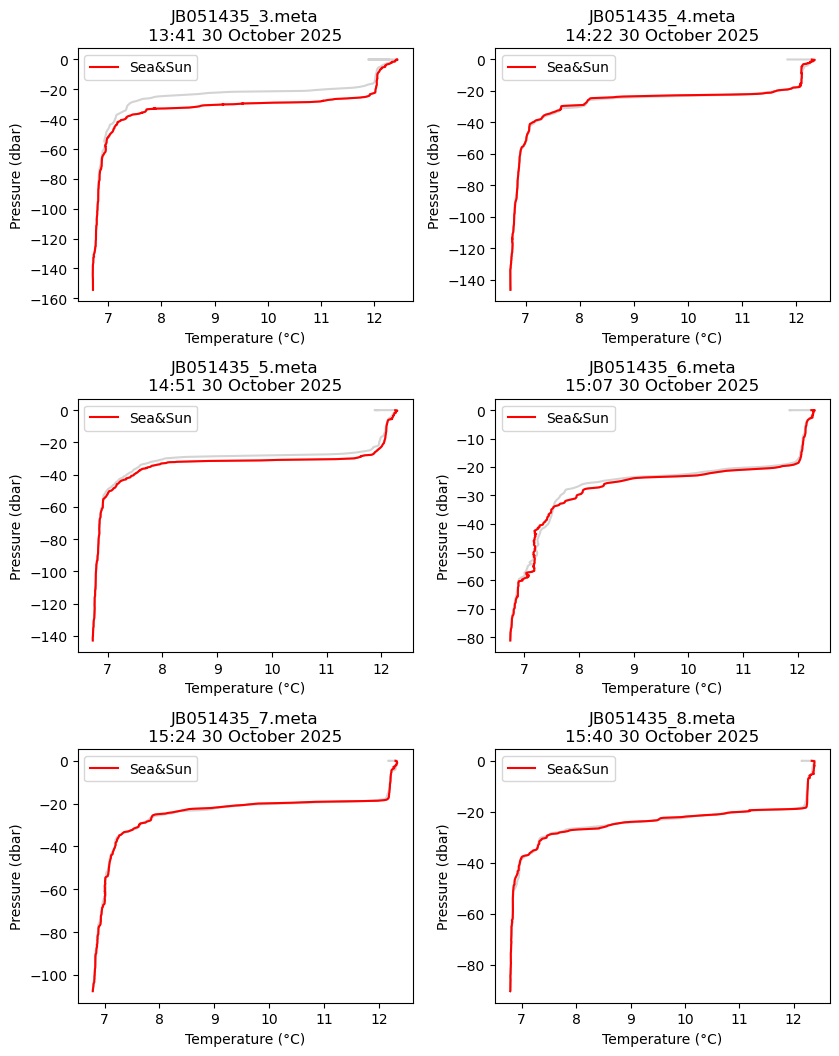

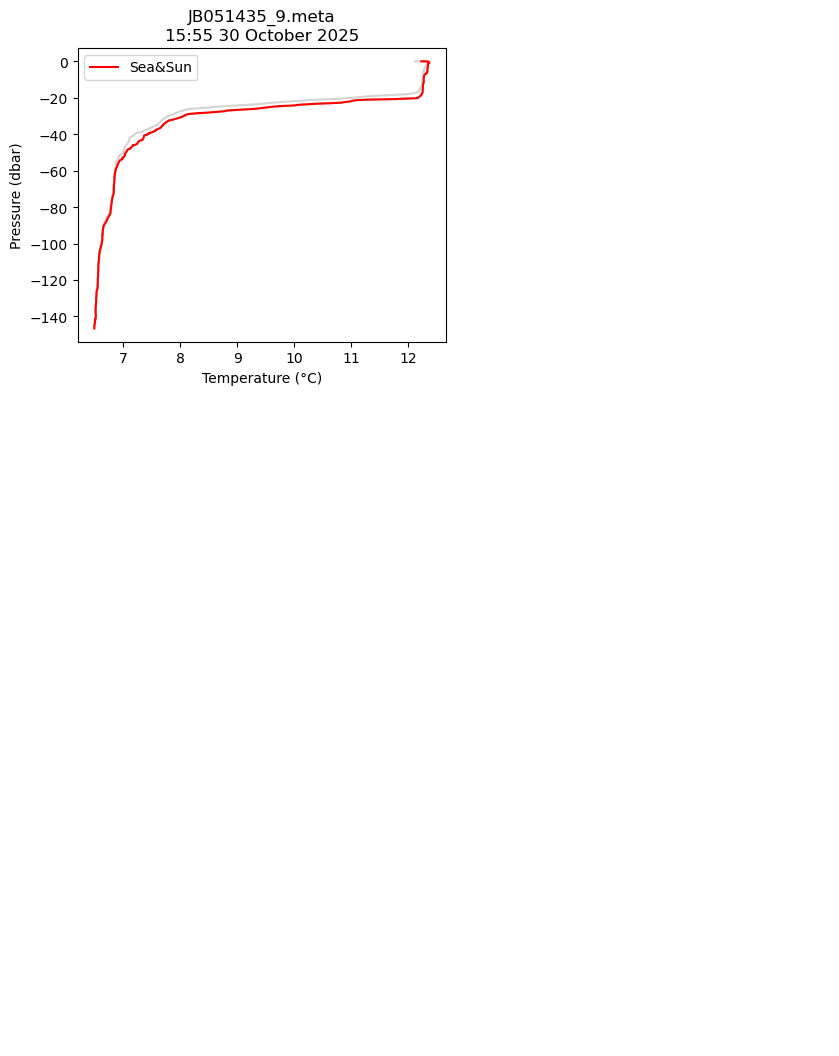

In [53]:
process_profiles(profiles, None, None)

#### Lake Zug (21.11.2025)

In [14]:
path  = "Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/VerticalProfiles/to_be_processed/20251121/"
files = create_file_list(path)
profiles = []
for f in files:
    try:
        profiles.extend(read_sea_and_sun(f['path']))
    except Exception:
        continue

Failed to locate start of profile
Failed to locate start of profile


In [16]:
len(profiles)

15

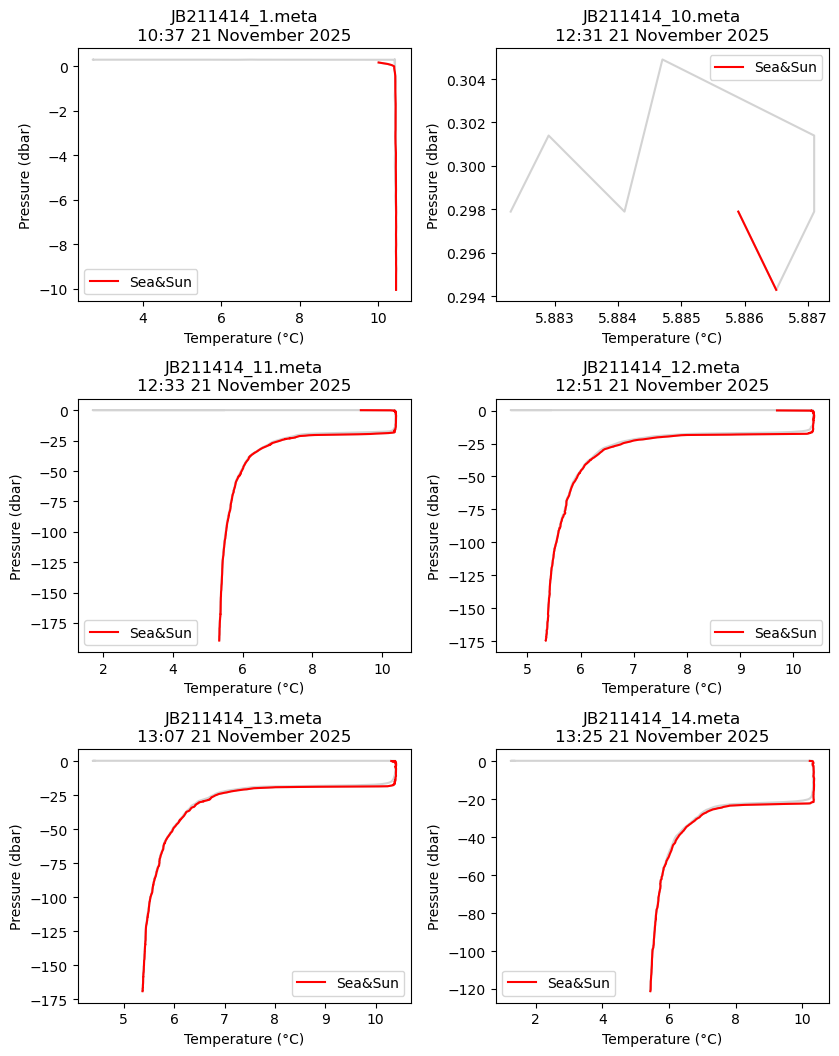

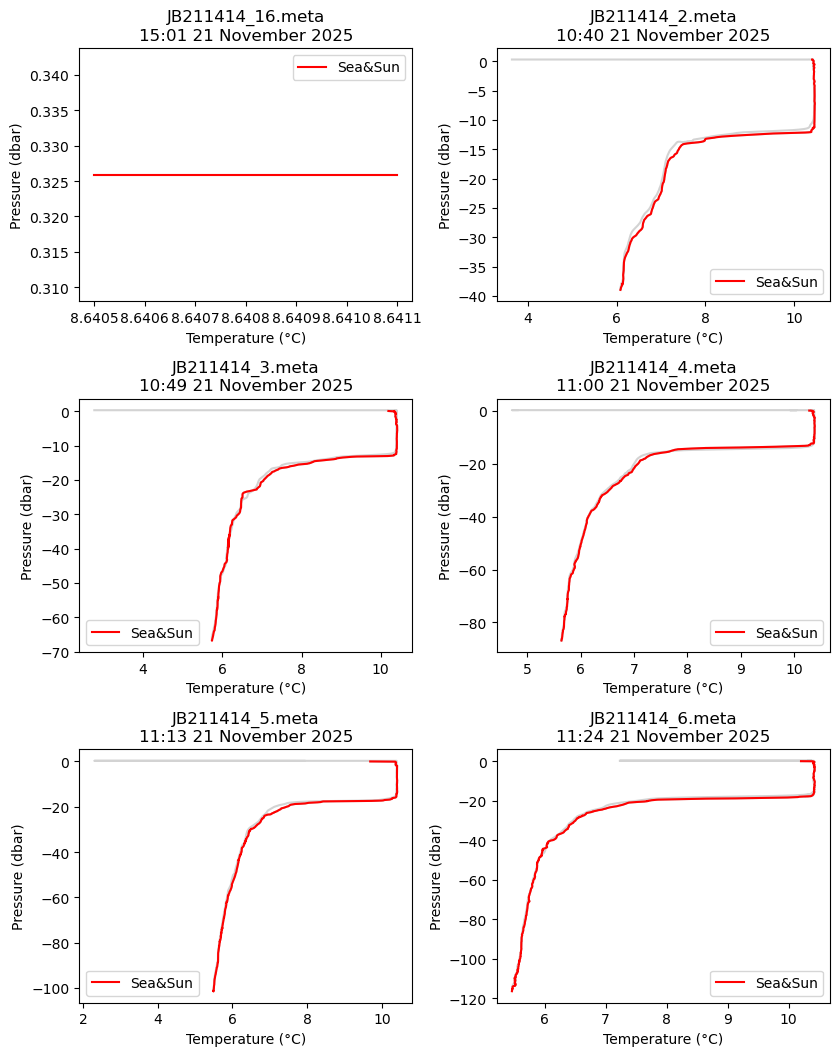

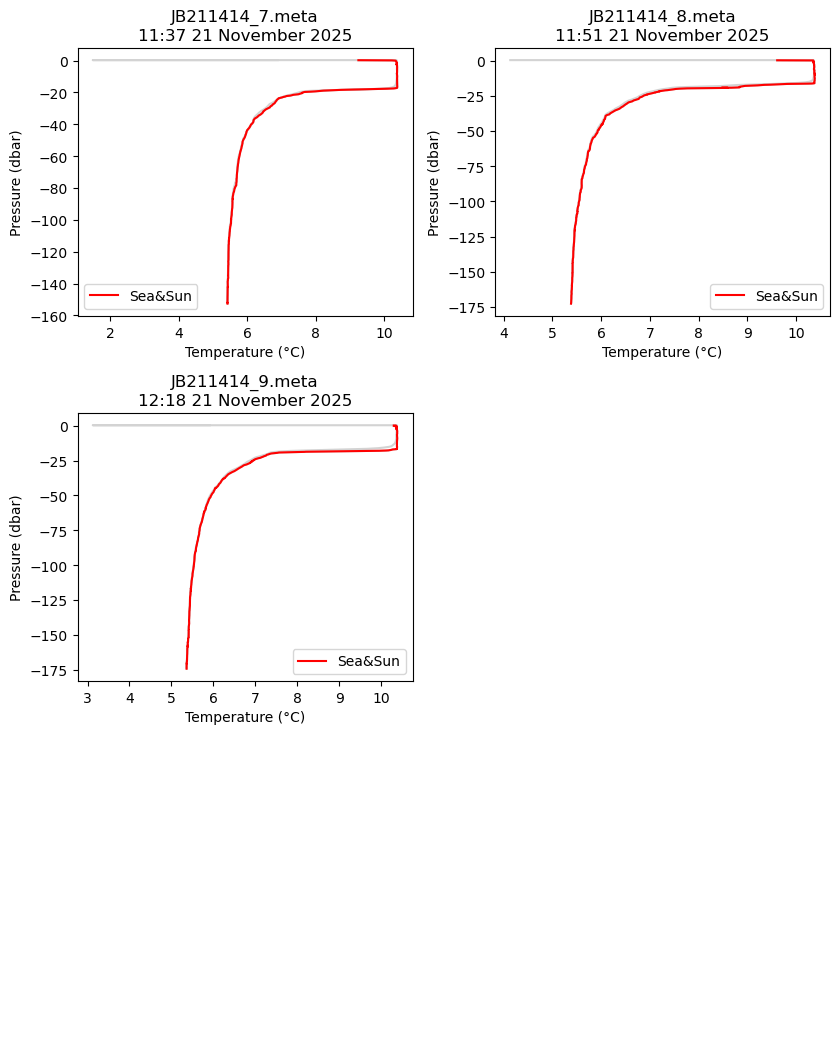

In [17]:
process_profiles(profiles, None, None)